In [ ]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

**Data**

In [ ]:
## cp = chest pain, trestbps = resting blood pressure, fbs = fasting blood sugar > 120 mg/dl, restecg = resting electrocardiographic results
## thalach = maximum heart rate achieved, exang = exercise induced chest pain, oldpeak = ST depression induced by exercise
## slope = he slope of the peak exercise ST segment, Value 1: upsloping, Value 2: flat, Value 3: downsloping
## ca = number of major vessels(0-3), thal = 3 = normal; 6 = fixed defect; 7 = reversable defect, num = diagnosis of heart disease

col_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
               "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")

heart_data <- read.table("Data/processed.cleveland.data", 
                         col.names = col_names, sep = ",")


heart_data_anaylsis <- heart_data |> 
    select(age, sex, chol, trestbps, num)
heart_data_anaylsis


number_of_rows <- heart_data_anaylsis |> 
    nrow()
number_of_rows

age,sex,chol,trestbps,num
<dbl>,<dbl>,<dbl>,<dbl>,<int>
63,1,233,145,0
67,1,286,160,2
67,1,229,120,1
⋮,⋮,⋮,⋮,⋮
57,1,131,130,3
57,0,236,130,1
38,1,175,138,0


[1] 303

**Training Data**
we will have 303 points as our training data

**Summarized Tables**

*Below is the table for the mean of the columns that we selected age, chol, and resting blood pressure*

In [ ]:
column_mean <- heart_data_anaylsis |> 
    select(age, chol, trestbps)|> 
    map_df(mean)
column_mean

age,chol,trestbps
<dbl>,<dbl>,<dbl>
54.43894,246.6931,131.6898


*Below is the table of the spread of the different scales of diagnosis of heart disease*


In [ ]:
num_counts <- heart_data_anaylsis |> 
    group_by(num) |> 
    count()
num_counts

num,n
<int>,<int>
0,164
1,55
2,36
3,35
4,13


*Below is the table of the spread of the different sex in the dataset*

In [5]:
sex_counts <- heart_data_anaylsis |> 
    group_by(sex) |> 
    count() |>
    mutate(sex = as_factor(sex)) 
sex_counts

## 0 == Female
## 1 == Male

sex,n
<fct>,<int>
0,97
1,206


**Initial Visualizations**

*Below is the line graph that represents each of the three numerical factors against the diagnosis of heart diseases*

<<<<<<< local


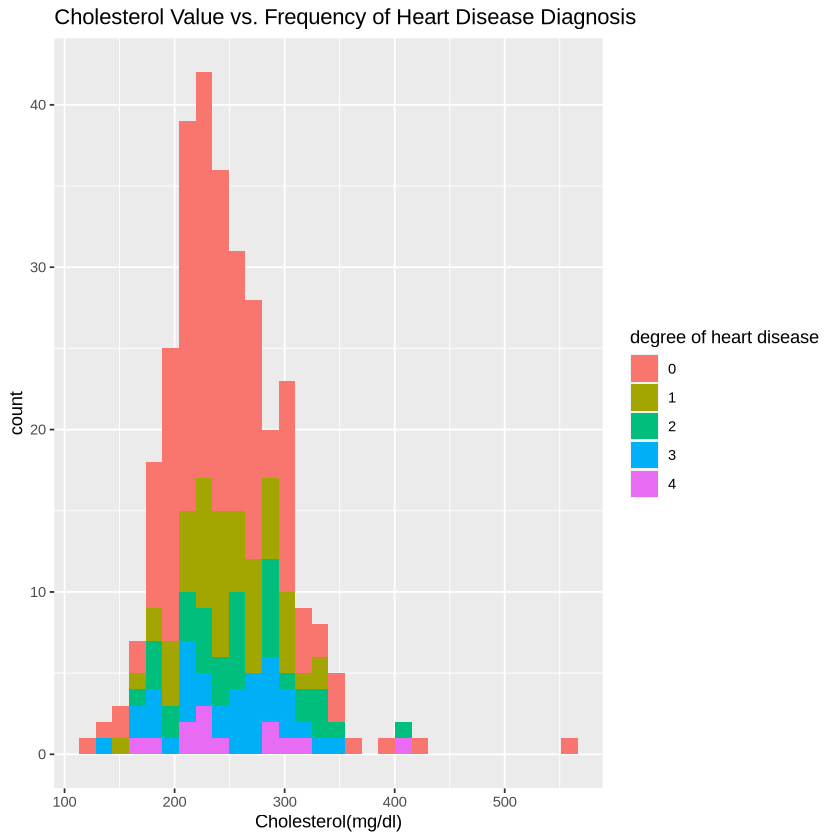

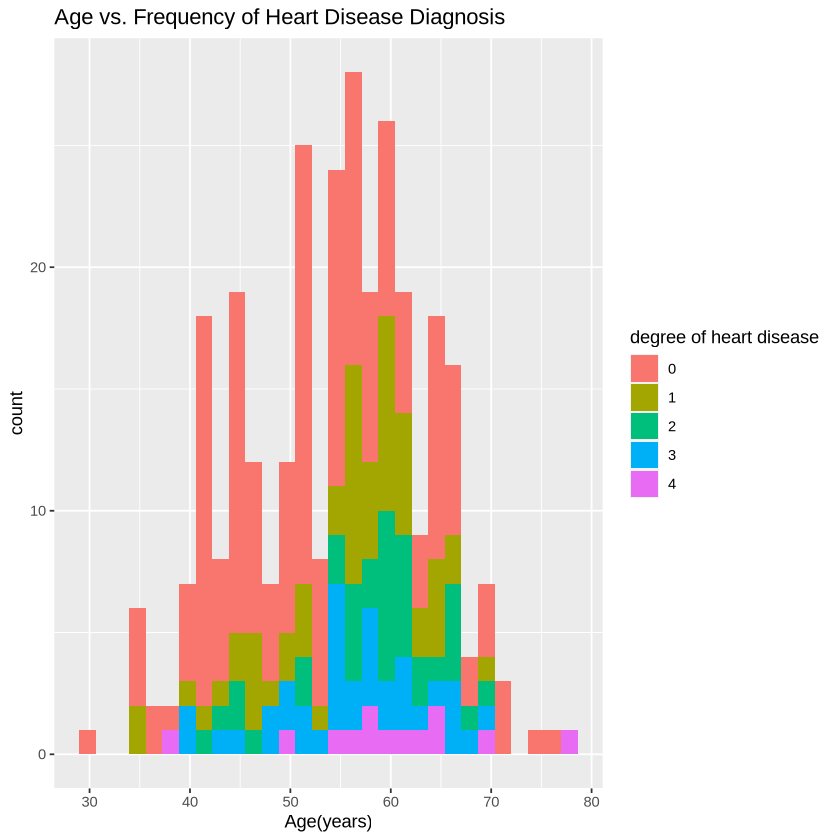

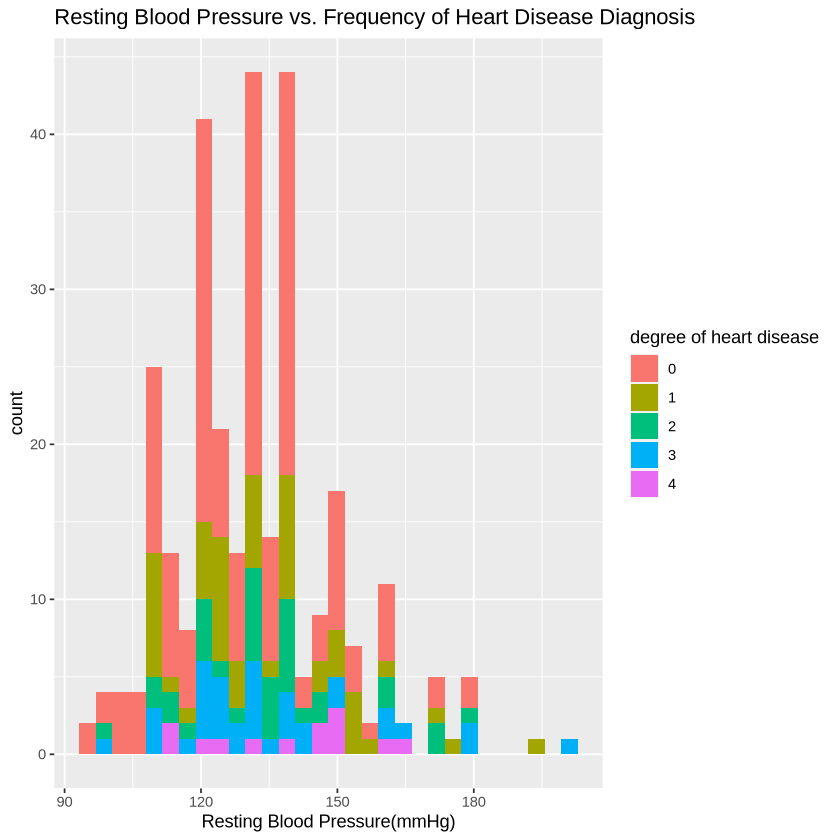

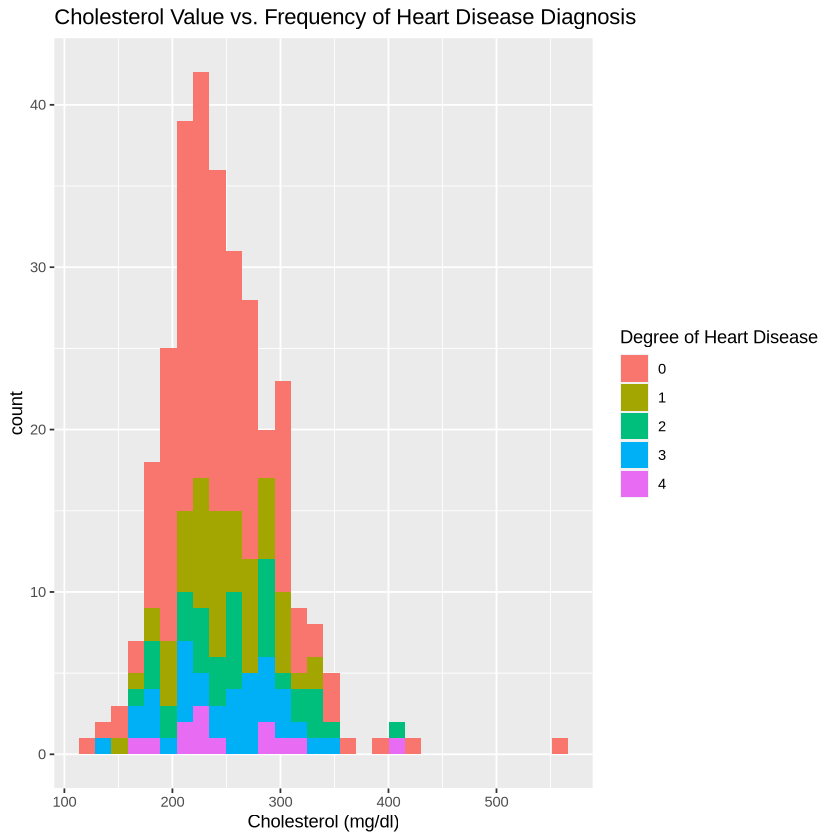

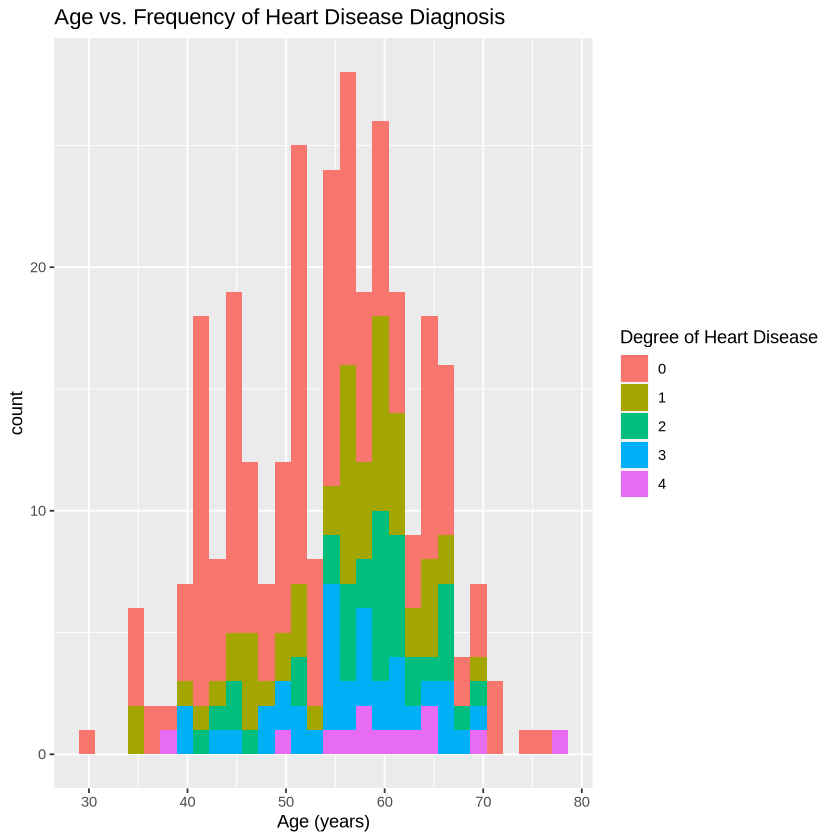

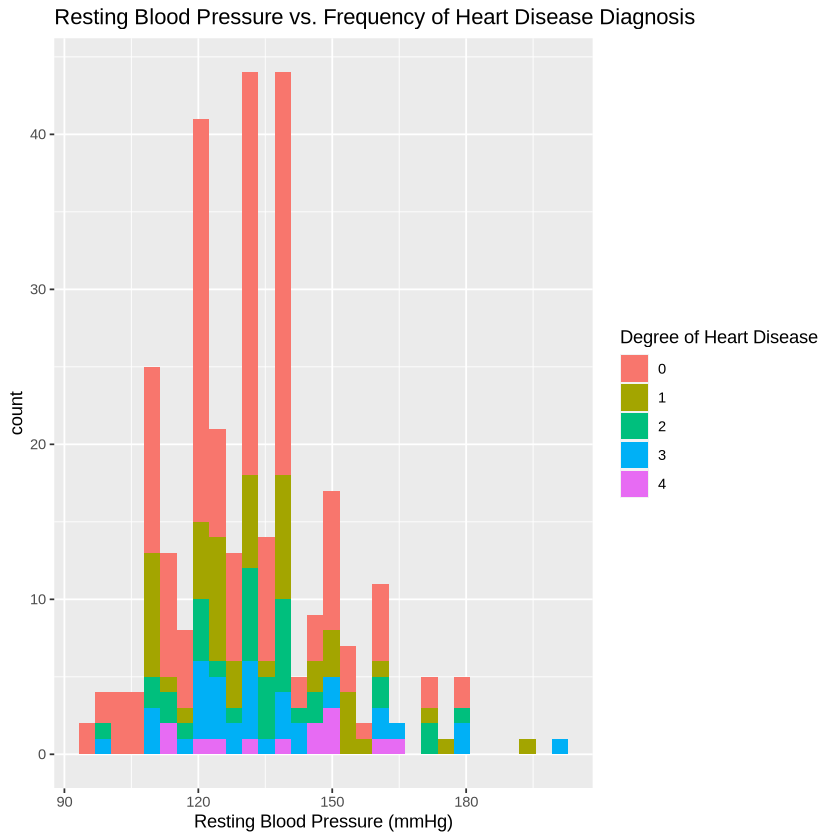

>>>>>>> remote


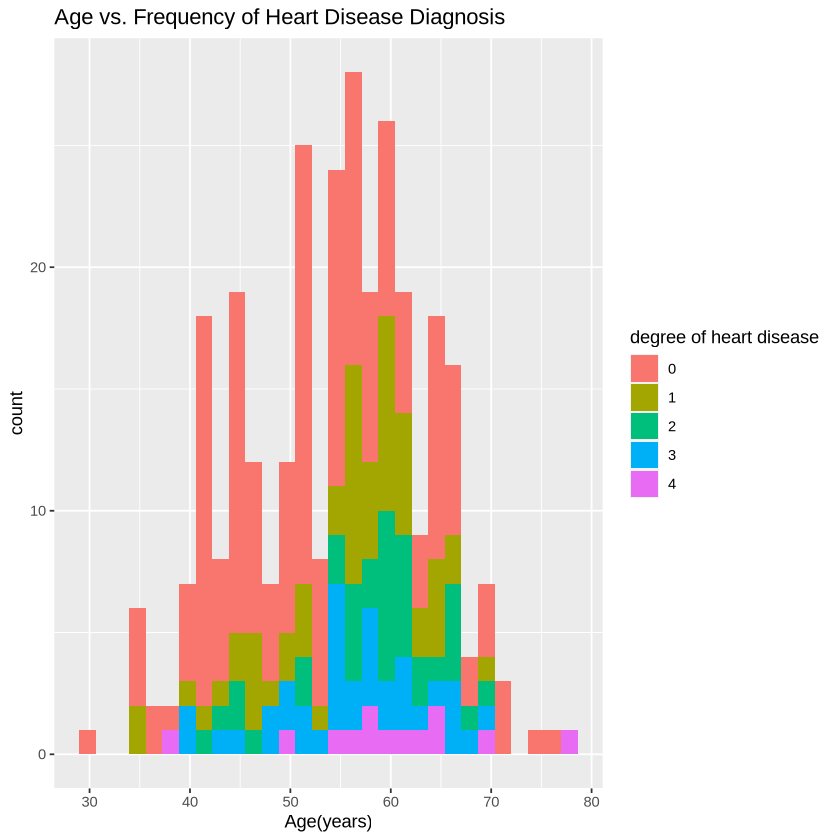

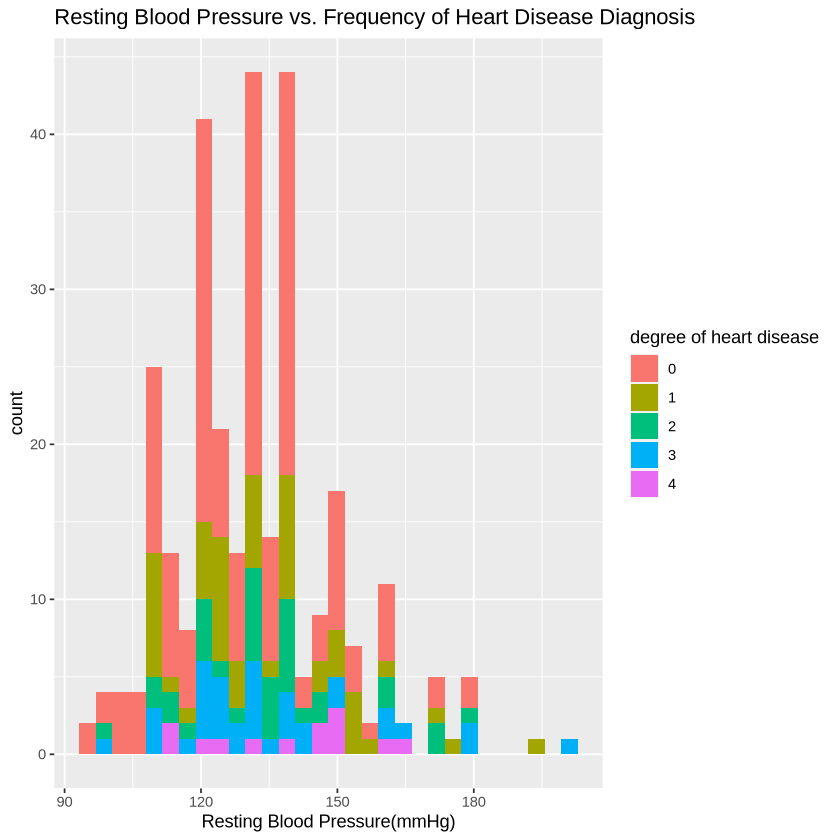

In [ ]:
chol_trend_graph <- heart_data_anaylsis |> ggplot(aes(x = chol, fill = factor(num))) + 
    geom_histogram(bins = 30) +
    labs(x = "Cholesterol (mg/dl)", 
         title = "Cholesterol Value vs. Frequency of Heart Disease Diagnosis", 
         fill = "Degree of Heart Disease")

age_trend_graph <- heart_data_anaylsis |> 
    ggplot(aes(x = age, fill = factor(num))) + 
    geom_histogram(bins = 30) + 
    labs(x = "Age (years)", 
         title = "Age vs. Frequency of Heart Disease Diagnosis", 
         fill = "Degree of Heart Disease")

trestbps_trend_graph <- heart_data_anaylsis |> 
    ggplot(aes(x = trestbps, fill = factor(num))) + 
    geom_histogram(bins = 30) + 
    labs(x = "Resting Blood Pressure (mmHg)", 
         title = "Resting Blood Pressure vs. Frequency of Heart Disease Diagnosis", 
         fill = "Degree of Heart Disease")

chol_trend_graph
age_trend_graph
trestbps_trend_graph

**Testing Data**

In [ ]:
## Data of patients

patient_data <- read_csv("Data/Heart_Disease_Prediction.csv") |> select('Heart Disease', Age, Sex, Cholesterol, BP)

patient_data 

Rows: 270 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Heart Disease
dbl (14): index, Age, Sex, Chest pain type, BP, Cholesterol, FBS over 120, E...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Heart Disease,Age,Sex,Cholesterol,BP
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Presence,70,1,322,130
Absence,67,0,564,115
Presence,57,1,261,124
⋮,⋮,⋮,⋮,⋮
Absence,56,0,294,140
Absence,57,1,192,140
Presence,67,1,286,160
